# https://www.kaggle.com/c/mercari-price-suggestion-challenge 

In [1]:
import matplotlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.pipeline import make_union, make_pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from lightgbm import LGBMRegressor

%matplotlib inline
sns.set()
plt.rcParams["figure.figsize"] = (20, 10)
pd.options.display.float_format = '{:.2f}'.format

### Используйте параметр nrows, чтобы уменьшить выборку и сделать базовый разведочный анализ данных

In [2]:
df = pd.read_csv('train.tsv', sep='\t', index_col=0)

/Users/afetisov/anaconda/envs/BD/lib/python3.6/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


And why would index_col usage result in any comparisons?

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1482535 entries, 0 to 1482534
Data columns (total 7 columns):
name                 1482535 non-null object
item_condition_id    1482535 non-null int64
category_name        1476208 non-null object
brand_name           849853 non-null object
price                1482535 non-null float64
shipping             1482535 non-null int64
item_description     1482531 non-null object
dtypes: float64(1), int64(2), object(4)
memory usage: 90.5+ MB


In [4]:
df.head()

,name,item_condition_id,category_name,brand_name,price,shipping,item_description
train_id,,,,,,,
0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.00,1,No description yet
1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.00,0,This keyboard is in great condition and works ...
2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.00,1,Adorable top with a hint of lace and a key hol...
3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.00,1,New with tags. Leather horses. Retail for [rm]...
4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.00,0,Complete with certificate of authenticity


In [5]:
df_test = pd.read_csv('test.tsv', sep='\t', index_col=0)

In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 693359 entries, 0 to 693358
Data columns (total 6 columns):
name                 693359 non-null object
item_condition_id    693359 non-null int64
category_name        690301 non-null object
brand_name           397834 non-null object
shipping             693359 non-null int64
item_description     693359 non-null object
dtypes: int64(2), object(4)
memory usage: 37.0+ MB


In [7]:
df_test.head()

,name,item_condition_id,category_name,brand_name,shipping,item_description
test_id,,,,,,
0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7
1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...
3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...
4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...


# Задание
1. Сделать baseline submission
  * Исследовать признак price. 
  * Исследовать признак price в зависимости от brand_name или других признаков
2. Реализовать цикл анализа
  * признаки -> модель -> настройка параметров -> лучшая модель и ее значение метрики качества на кросс-валидации
3. Провести простые преобразования признаков и добавление простых признаков
  * разделить category_name на уровни
  * посмотреть на наличие числовых значений в описании и имени
  * ...
4. Составить план по применению нескольких моделей на разных признаках
  * спроектируйте эксперимент. Нужно заранее спланировать порядок перебора признаков и моделей. Потом только писать код. Обратный порядок вызывает необходимость переписывать существующий код, это трата времени
5. Просмотреть 1-5 kernel на kaggle. (только в таком порядке. сначала работаем самостоятельно, потом смотрим идеи других. при появлении опыта можно сразу начинать с них)
6. Скорректировать план
  * убрать пункты, которые кажутся неудачными
  * добавить идеи из kernel, кажущиеся удачными
7. Построить модель, выбрать лучшую
8. Построить ансамбль, настрить парамертры. Сравнить с другими моделями.
9. Применить и засабмитить лучшую на cv модель
10. Прислать блокнот и свой ник в лидерборде

### Exploration

#### name

In [8]:
sum(df.name.isnull())

0

It contains formal decription of an item; TF-IDFing most frequent words should do just fine.

#### item_condition_id

In [9]:
df.item_condition_id.unique()

array([3, 1, 2, 4, 5])

Ready-to-use feature, we need to just OHE it

#### category_name

In [10]:
df.category_name.unique().shape

(1288,)

In [11]:
sum(df.category_name.isnull())

6327

In [12]:
df.category_name.fillna("//").str.split("/").apply(lambda x: x[0]).unique().shape

(11,)

In [13]:
df.category_name.fillna("//").str.split("/").apply(lambda x: x[1]).unique().shape

(114,)

In [14]:
df.category_name.fillna("//").str.split("/").apply(lambda x: x[2]).unique().shape

(871,)

In [15]:
df.groupby("category_name").agg({"price": "mean"}).sort_values("price", ascending=False).head(10)

,price
category_name,
Vintage & Collectibles/Antique/Furniture,195.00
Handmade/Bags and Purses/Clutch,180.22
Electronics/Computers & Tablets/Laptops & Netbooks,177.09
Kids/Strollers/Standard,163.67
Electronics/Computers & Tablets/Desktops & All-In-Ones,149.33
Vintage & Collectibles/Bags and Purses/Handbag,139.56
Kids/Strollers/Travel Systems,124.60
Home/Home Appliances/Air Conditioners,121.14
Kids/Strollers/Lightweight,117.11


It makes sense to split categories and their subcategories and OHE them all, CountVectorizer should make it almost automatically.

#### brand_name

In [16]:
sum(df.brand_name.isnull())

632682

In [17]:
df.brand_name.unique().shape

(4810,)

In [18]:
df.groupby("brand_name").agg({"price": "mean"}).sort_values("price", ascending=False).head(10)

,price
brand_name,
Demdaco,429.00
Proenza Schouler,413.25
Auto Meter,344.00
Oris,300.00
MCM Worldwide,289.17
Longines,254.00
Vitamix,253.11
Blendtec,251.80
David Yurman,248.61


Brand *clearly* has a significant influence on the price.  
We need to replace NaNs with *some* class, then perform label encoding and OHE.

#### price

In [19]:
sum(df.price.isnull())

0

Whew, no NaNs

In [20]:
df.price.describe()

count   1482535.00
mean         26.74
std          38.59
min           0.00
25%          10.00
50%          17.00
75%          29.00
max        2009.00
Name: price, dtype: float64

In [21]:
df.price.quantile(0.9)

51.0

In [22]:
df.price.quantile(0.99)

170.0

Very skewed distribution

In [23]:
sum(df.price == 0)

874

Why? Does someone just give away goods?

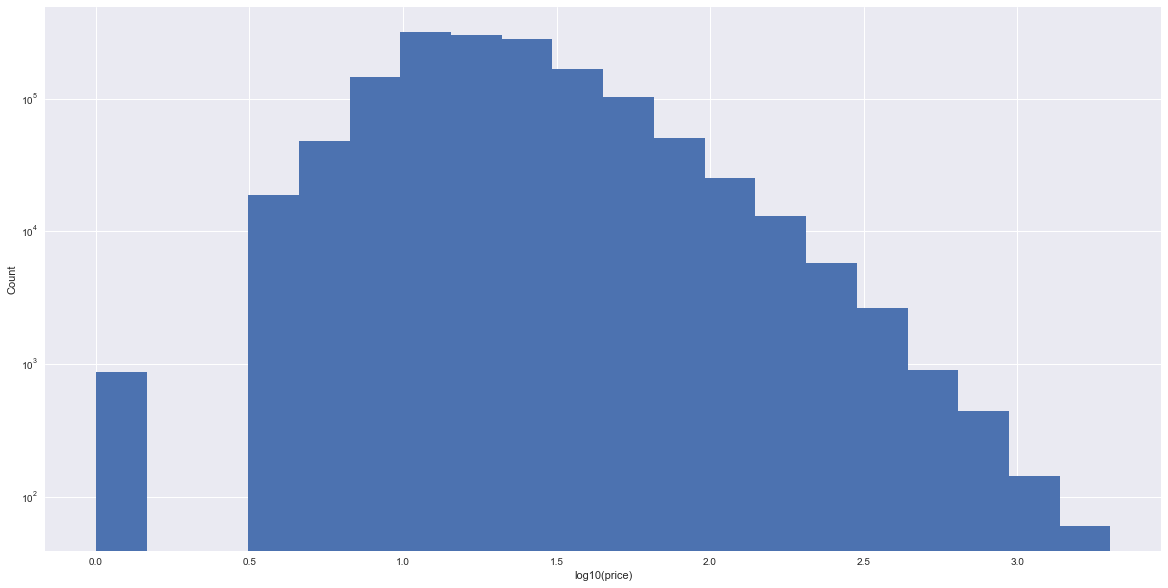

In [24]:
plot = np.log10(df.price + 1).hist(bins=20, log=True)
plot.set_ylabel("Count")
plot.set_xlabel("log10(price)")

Using this as a target with some linear regressors could pose a problem due to skeweness. One solution is to use `log(price)` instead or, even better, `log(price+1)` (because of zeroes)

#### shipping

In [25]:
df.shipping.unique().shape

(2,)

In [26]:
df.groupby("shipping").agg({"price": "mean"})

,price
shipping,
0,30.11
1,22.57


Just a nice binary feature, can be use as-is.

#### item_description

In [27]:
sum(df.item_description.isnull())

4

It's likely that this feature contains some sentient text, that could greatly improve prediction.  
There're many possible approaches. One of them is to TF-IDF it with sensible constraints, maybe even try n-grams.  
However, it could take more then one attempt to find out how generous Kaggle execution environment is.

### Data preparation

In [28]:
class LabelEncoderPipelineFriendly(LabelEncoder):
    def __init__(self, **kwargs):
        super(LabelEncoderPipelineFriendly, self).__init__(**kwargs)
    
    def fit(self, X, y=None):
        """this would allow us to fit the model based on the X input."""
        super(LabelEncoderPipelineFriendly, self).fit(X)
        
    def transform(self, X, y=None):
        return super(LabelEncoderPipelineFriendly, self).transform(X).reshape(-1, 1)

    def fit_transform(self, X, y=None):
        return super(LabelEncoderPipelineFriendly, self).fit(X).transform(X).reshape(-1, 1)

In [29]:
def prepare_data(train, test):
    def get_name_col(df):
        return df["name"]
    
    def get_condition_col(df):
        return df[["item_condition_id"]]
    
    def get_category_col(df):
        return df["category_name"].fillna("None").astype("category")
    
    def get_brand_col(df):
        return df["brand_name"].fillna("None").astype("category")
    
    def get_shipping_col(df):
        return df[["shipping"]]
    
    def get_desc_col(df):
        return df["item_description"].fillna("None")
    
    p = make_union(*[
        make_pipeline(FunctionTransformer(get_name_col, validate=False), 
                      TfidfVectorizer(min_df=15)), # we really don't want to end up with a gazzilion of columns
        make_pipeline(FunctionTransformer(get_condition_col, validate=False),
                      OneHotEncoder()),
        make_pipeline(FunctionTransformer(get_category_col, validate=False),
                      CountVectorizer()),
        make_pipeline(FunctionTransformer(get_brand_col, validate=False),
                      LabelEncoderPipelineFriendly(),
                      OneHotEncoder(sparse=True)),
        make_pipeline(FunctionTransformer(get_shipping_col, validate=False)),
        make_pipeline(FunctionTransformer(get_desc_col, validate=False),
                      TfidfVectorizer(ngram_range=(1, 3), 
                                      stop_words="english", 
                                      max_features=10000))
        ])
    
    train_rows = train.shape[0]
    df = pd.concat([train, test], axis=0)
    transformed = p.fit_transform(df)
    transformed_train, transformed_test = transformed[:train_rows], transformed[train_rows:]
    del df
    return (transformed_train, transformed_test)

In [30]:
X, X_test = prepare_data(df, df_test) # we need both of them to reliably get every categorical level
y = np.array(df.price)
log_y = np.log1p(y)

In [31]:
X.shape, X_test.shape, y.shape

((1482535, 33674), (693359, 33674), (1482535,))

#### Baseline

In [32]:
# https://www.kaggle.com/wiki/RootMeanSquaredLogarithmicError
def rmsle(h, y): 
    return np.sqrt(np.square(np.log(h + 1) - np.log(y + 1)).mean())
scorer = make_scorer(score_func=rmsle, greater_is_better=False)

In [33]:
# three linear models and one tree
models = [
    ("Lasso", Lasso, {"alpha": [0.1, 0.5], # bigger alpha -> bigger error
                      "random_state": [0],
                      "max_iter": [1000],
                      "tol": [0.001],
                      "selection": ["random"],
                      "fit_intercept": [False]}), # everything is normalized, thanks to TF-IDF
    ("Ridge", Ridge, {"solver": ["lsqr", "sparse_cg"], # svd doesn't support sparse matrices
                      "alpha": [0.1, 0.5, 1],    # cholesky is slow, as well as sag and saga
                      "random_state": [0],
                      "tol": [0.001],
                      "fit_intercept": [False]}),
    ("ElasticNet", ElasticNet, {"alpha": [0.1, 0.5], # bigger alpha -> bigger error
                                "l1_ratio": [0.1, 0.5, 0.9],
                                "random_state": [0],
                                "max_iter": [1000],
                                "tol": [0.001],
                                "selection": ["random"],
                                "fit_intercept": [False]}),
    ("DecisionTreeRegressor", DecisionTreeRegressor, {"max_depth": [3, 7], # more depth -> slower learning rate
                                                      "random_state": [0]})
]

In [34]:
best_models = []

for name, model_class, params in models:
    gs = GridSearchCV(model_class(), params, scoring=scorer, cv=5, n_jobs=1, refit=True)
    gs.fit(X, log_y)
    best_models.append((name, model_class, gs.best_estimator_, gs.best_params_, gs.best_score_))

In [35]:
for model_name, _, estimator, _, _ in best_models:
    predicted = np.expm1(estimator.predict(X_test))
    pd.DataFrame({"price": predicted}, index=df_test.index).to_csv("baseline_{}.csv".format(model_name), sep=",")

### Ensembles

Anyone can just apply XGBoost or RandomForest. Let's stack our very own ensemble with the baseline models and LGBMRegressor!  
Alas, we're really out of time here, so, no CV for ensemble.

In [36]:
lgr = LGBMRegressor(n_jobs=-1, n_estimators=100)
lgr.fit(X, log_y, eval_metric=rmsle)

LGBMRegressor(boosting_type='gbdt', colsample_bytree=1.0, learning_rate=0.1,
       max_bin=255, max_depth=-1, min_child_samples=10, min_child_weight=5,
       min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
       objective=None, random_state=0, reg_alpha=0.0, reg_lambda=0.0,
       silent=True, subsample=1.0, subsample_for_bin=50000,
       subsample_freq=1)

In [37]:
best_models.append(("LGBMRegressor", LGBMRegressor, lgr, lgr.get_params(), lgr.best_score_))

In [38]:
all_models_preds_train = np.zeros((X.shape[0], len(best_models)))
for i in range(len(best_models)):
    _, _, estimator, _, _ = best_models[i]
    all_models_preds_train[..., i] = estimator.predict(X)

In [39]:
all_models_preds_test = np.zeros((X_test.shape[0], len(best_models)))
for i in range(len(best_models)):
    _, _, estimator, _, _ = best_models[i]
    all_models_preds_test[..., i] = estimator.predict(X_test)

In [40]:
lr = LinearRegression()
lr.fit(all_models_preds_train, log_y)
final_preds = np.expm1(lr.predict(all_models_preds_test))

In [41]:
pd.DataFrame({"price": final_preds}, index=df_test.index).to_csv("ensemble.csv", sep=",")